# Stratified K-Fold

参考サイト


[Python: 層化抽出法を使ったK-分割交差検証 (Stratified K-Fold CV)](https://blog.amedama.jp/entry/2018/08/25/174530)

ここまでで作成したシード値、訓練データと検証データの学習、予測の自作関数をライブラリーからimportする。

In [1]:
from Library_chr2.seed import seed_torch
from Library_chr2.train_1epoch import train_1epoch
from Library_chr2.validate_1epoch import validate_1epoch
from Library_chr2.predict import predict

In [2]:
import numpy as np
import torch
from sklearn.datasets import load_digits
from sklearn.model_selection import StratifiedKFold, train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

## ① シード値の固定とデータ準備

In [3]:
seed_torch()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

digits = load_digits()
X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# データをpytorchで使える形へ（データセットとデータローダーの準備）
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## ② モデルの準備
- モデルの作成
- 損失関数の準備
- 最適化アルゴリズムの選択

In [4]:
model = nn.Sequential(
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 10)
)

model = model.to(device)

lossfun = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

## ③　KFold法の適用

In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True)
oof_train = np.zeros((len(X_train), 10))
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
test_preds = []

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train, y_train)):
    X_tr, X_val = X_train[train_index], X_train[valid_index]
    y_tr, y_val = y_train[train_index], y_train[valid_index]

    X_tr = torch.tensor(X_tr, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_tr = torch.tensor(y_tr, dtype=torch.int64)
    y_val = torch.tensor(y_val, dtype=torch.int64)

    train_dataset = TensorDataset(X_tr, y_tr)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    for ep in range(100):
        train_acc, train_loss = train_1epoch(
            model, train_loader, lossfun, optimizer, device
        )

        valid_acc, valid_loss = validate_1epoch(
            model, val_loader, lossfun, device
        )

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc.item())
    valid_accs.append(valid_acc.item())
    oof_train[valid_index] = predict(model, val_loader, device)
    test_preds.append(predict(model, test_loader, device))


print("train acc", np.mean(train_accs))
print("valid acc (各StratifiedKFoldの平均)", np.mean(valid_accs))
print(
    "valid acc (再計算)",
    sum(y_train == np.argmax(oof_train, axis=1)) / len(y_train),
)

test_preds = np.mean(test_preds, axis=0)
test_preds = np.argmax(test_preds, axis=1)

print(
    "test acc",
    sum(y_test.detach().numpy().copy() == test_preds) / len(y_test),
)


100%|██████████| 9/9 [00:00<00:00, 2347.41it/s]


train acc 1.0
valid acc (各StratifiedKFoldの平均) 1.0
valid acc (再計算) 1.0
test acc 0.9685185185185186


本書通り、テストセット（test acc）がK-Foldの結果よりも若干良くなっている

### ④ 可視化

100%|██████████| 9/9 [00:00<00:00, 2163.50it/s]

train acc 1.0
valid acc 1.0


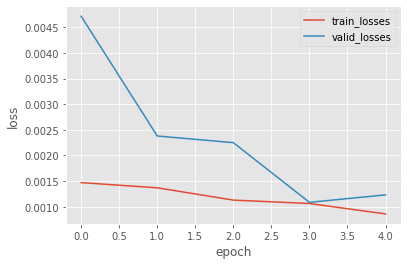

In [11]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(train_losses, label="train_losses")
plt.plot(valid_losses, label="valid_losses")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

test_preds = predict(model, test_loader, device)

print("train acc", train_acc.item())
print("valid acc", valid_acc.item())
